In [91]:
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl
from astropy.io import fits
import pcmdpy as ppy
from scipy import signal
from scipy import misc
import seaborn as sns
%matplotlib inline

In [300]:
from matplotlib import cycler

# PSF Dithering

In [2]:
from scipy.signal import fftconvolve

In [302]:
f = ppy.instrument.default_ngc3377_filters()
iso_model = ppy.isochrones.Isochrone_Model(f)
driv = ppy.driver.Driver(iso_model)

GPU acceleration not available. Continuing without.

In [279]:
def bin_image(image, n=4):
    assert image.shape[0] % n == 0
    assert image.shape[1] % n == 0
    x1 = image.shape[0] // n
    x2 = image.shape[1] // n
    a = np.array([np.hsplit(d, x2) for d in np.vsplit(image, x1)])
    return a.sum(axis=-1).sum(axis=-1)

In [245]:
mpl.style.use('cook')

In [143]:
face = misc.face(gray=True)[::-1][:512, :512]

In [144]:
faces = np.array([np.hsplit(d, 256) for d in np.vsplit(face, 256)])

In [145]:
new_face = faces.sum(axis=-1).sum(axis=-1)

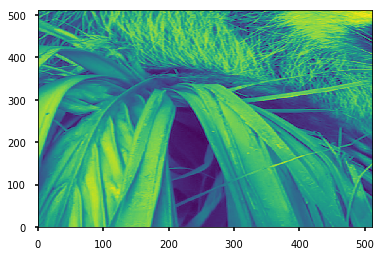

In [146]:
plt.imshow(face)

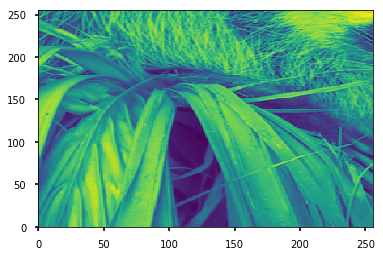

In [147]:
plt.imshow(new_face)

In [60]:
psfs = f[0].psf_model.dithered_psf

In [61]:
image = np.random.randint(0, 2, size=(256,256))

In [62]:
image = np.tile(image, (4,4))

In [63]:
image2 = f[0].psf_convolve(image, dither=True)
image3 = f[0].psf_convolve(image, dither=False)


In [64]:
image.mean(), image.std()

(0.5008392333984375, 0.4999992956868069)

In [65]:
image2.mean(), image2.std()

(0.5008392333984377, 0.10617255648310245)

In [66]:
image3.mean(), image3.std()

(0.5008392333984374, 0.11728169519892045)

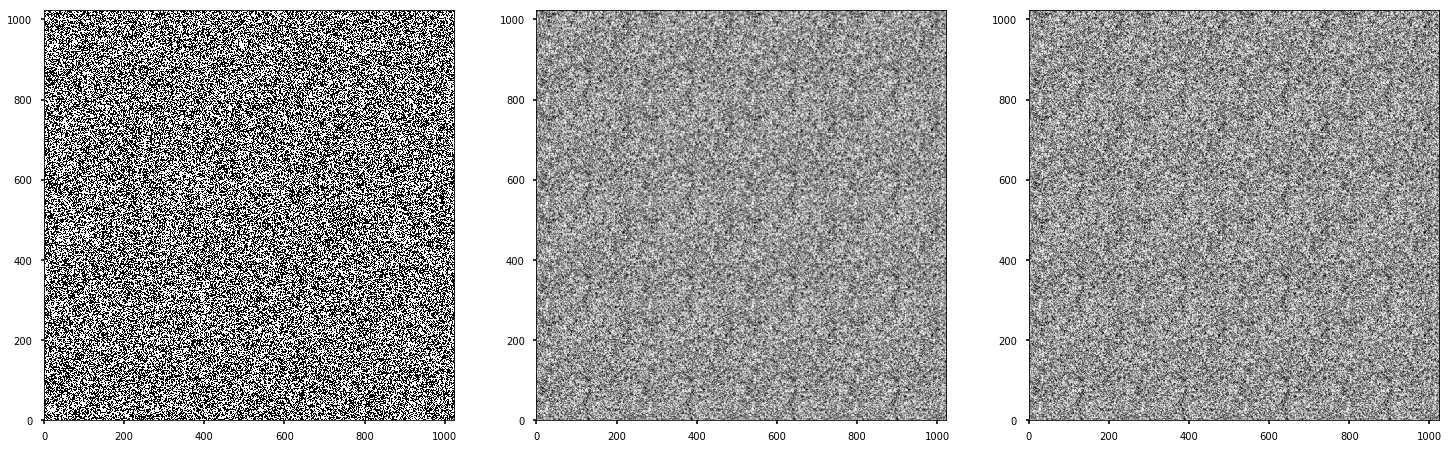

In [67]:
fig, axes = plt.subplots(ncols=3, figsize=(25, 8))
axes[0].imshow(image, cmap='Greys_r', aspect='equal')
axes[1].imshow(image2, cmap='Greys_r', aspect='equal')
axes[2].imshow(image3, cmap='Greys_r', aspect='equal')


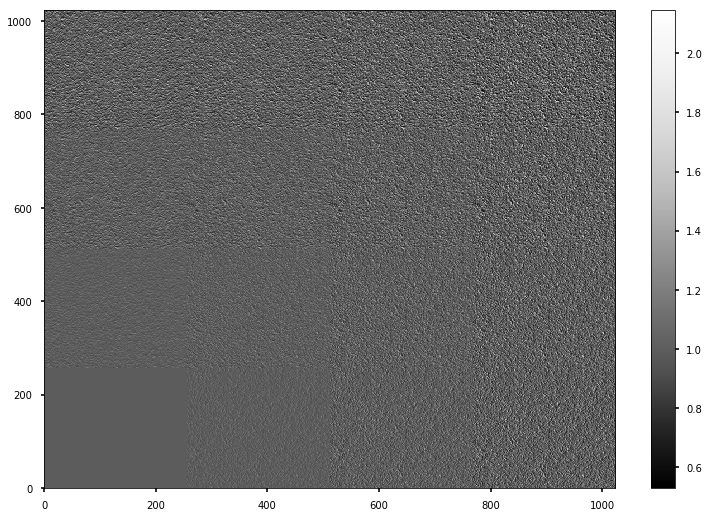

In [68]:
plt.imshow(image2/image3, cmap='Greys_r')
plt.colorbar()

In [69]:
image_subd = ppy.instrument.psf._subdivide_image(image, 4, w_border=f[0].psf_model._d_psf-1)

In [70]:
convolved_matrix = np.array([[fftconvolve(image_subd[i,j], psfs[i,j], mode='valid') for j in range(4)] for i in range(4)])

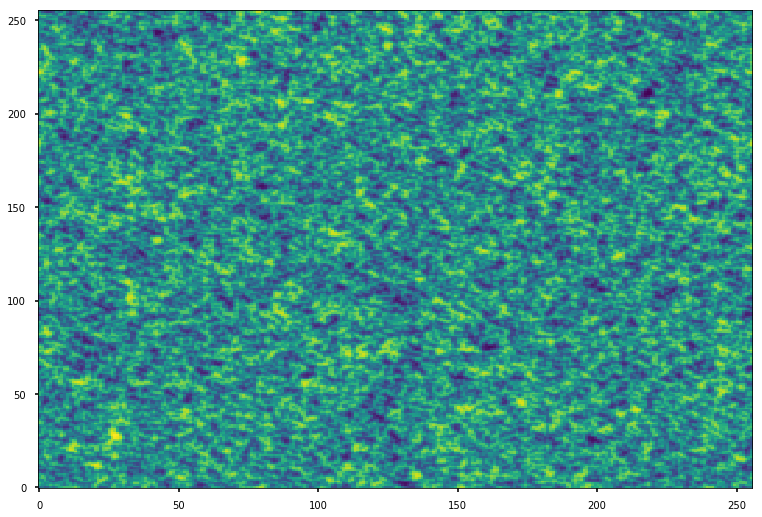

In [71]:
plt.imshow(convolved_matrix[0,0])

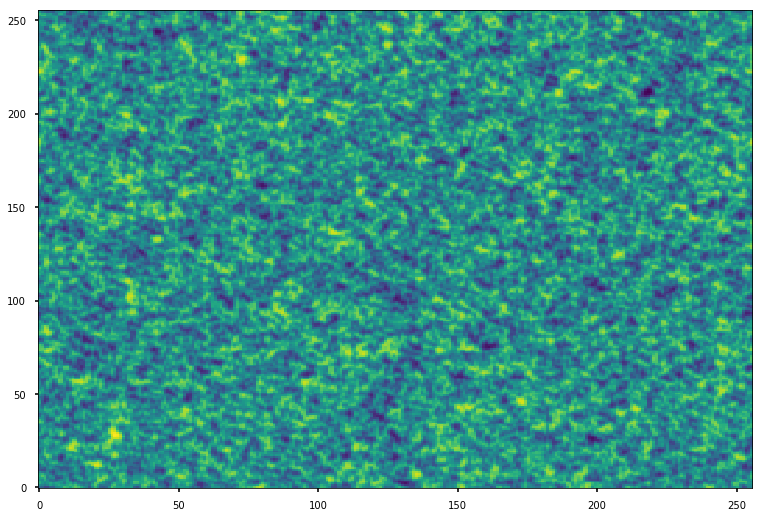

In [72]:
plt.imshow(convolved_matrix[2,0])

In [347]:
g = ppy.galaxy.SSPSimple(np.array([0.0, -2.0, 5.0, 10.0]))
_, (im5, _) = driv.simulate(g, 512, psf=False, shot_noise=False)

In [348]:
g = ppy.galaxy.SSPSimple(np.array([0.0, -2.0, 2.0, 10.0]))
_, (im2, _) = driv.simulate(g, 512, psf=False, shot_noise=False)

In [349]:
def get_psf_sims(image, width=0.1, n=4):
    binned = bin_image(image, n=n)
    psf = np.outer(signal.gaussian(50, width), signal.gaussian(50, width))
    psf1 = ppy.instrument.PSF_Model(psf/psf.sum())
    psf1.dithered_psf = ppy.instrument.psf._generate_dithered_images(psf1.psf, shifts=np.linspace(0., 1.0, n+1)[:-1])

    psf = np.outer(signal.gaussian(50, width*n), signal.gaussian(50, width*n))
    psf2 = ppy.instrument.PSF_Model(psf/psf.sum())
    c1 = f[0].counts_to_mag(psf1.convolve(binned, dither=False))
    c2 = f[0].counts_to_mag(psf1.convolve(binned, dither=True))
    c3 = f[0].counts_to_mag(bin_image(psf2.convolve(image, dither=False), n=n))
    return c1, c2, c3

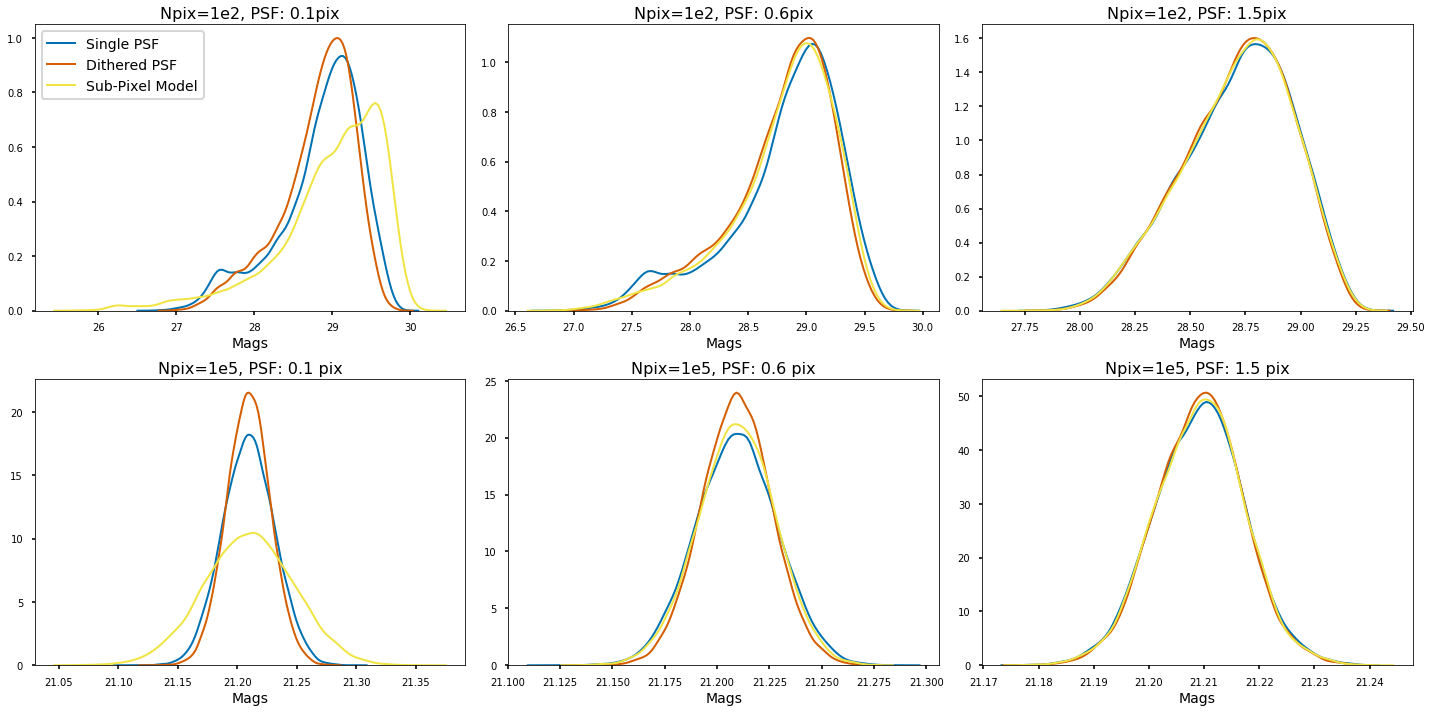

In [354]:
fig, axes = plt.subplots(figsize=(20, 10), ncols=3, nrows=2, sharex=False)
for i, w in enumerate([0.1, 0.6, 1.5]):
    a, b, c = get_psf_sims(im2, width=w, n=4)
    sns.kdeplot(a.flatten(), label='Single PSF', ax=axes[0,i])
    sns.kdeplot(b.flatten(), label='Dithered PSF', ax=axes[0,i])
    sns.kdeplot(c.flatten(), label='Sub-Pixel Model', ax=axes[0,i])
    axes[0,i].set_title(f'Npix=1e2, PSF: {w:.1f}pix')
    axes[0,i].set_xlabel('Mags')
    a, b, c = get_psf_sims(im5, width=w, n=4)
    sns.kdeplot(a.flatten(), label='Single PSF', ax=axes[1,i])
    sns.kdeplot(b.flatten(), label='Dithered PSF', ax=axes[1,i])
    sns.kdeplot(c.flatten(), label='Sub-Pixel Model', ax=axes[1,i])
    axes[1,i].set_title(f'Npix=1e5, PSF: {w:.1f} pix')
    axes[1,i].set_xlabel('Mags')
    if i == 0:
        axes[0,i].legend(loc=0)
        axes[1,i].get_legend().remove()
    else:
        axes[0,i].get_legend().remove()
        axes[1,i].get_legend().remove()
plt.tight_layout()
plt.savefig('figures/PSF_models.pdf')

In [296]:
np.mean(c1), np.mean(c2), np.mean(c3)

(21.210115432821127, 21.21007727005414, 21.21056635846125)

In [225]:
np.std(c1), np.std(c2), np.std(c3)

(205.58997189951194, 200.08085109277755, 202.68637944332036)

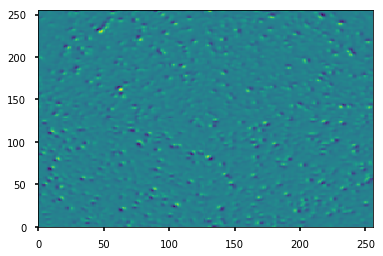

In [214]:
plt.imshow(c3 - c2)

In [174]:
c1.mean()

13559.165525018574

In [175]:
c2.mean()

13559.165525018569

In [178]:
c3.mean()

3389.7913812546412

In [76]:
psfs.sum(axis=-1).sum(axis=-1)

array([[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]])

In [67]:
im1 = fftconvolve(image, psfs[0,0], mode='valid')

In [99]:
im2 = fftconvolve(image, psfs[3,3], mode='same')

In [100]:
im1.mean()

123.60468635491478

In [101]:
im2.mean()

119.9667500830214

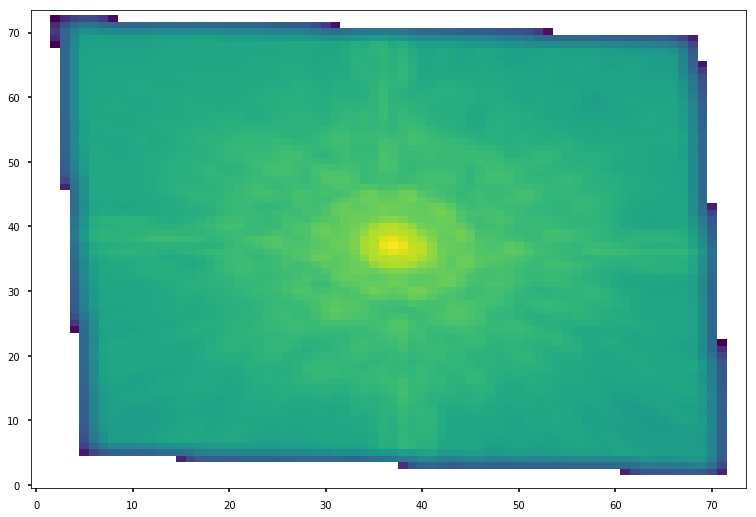

In [50]:
plt.imshow(psfs[0,0], norm=mpl.colors.LogNorm())

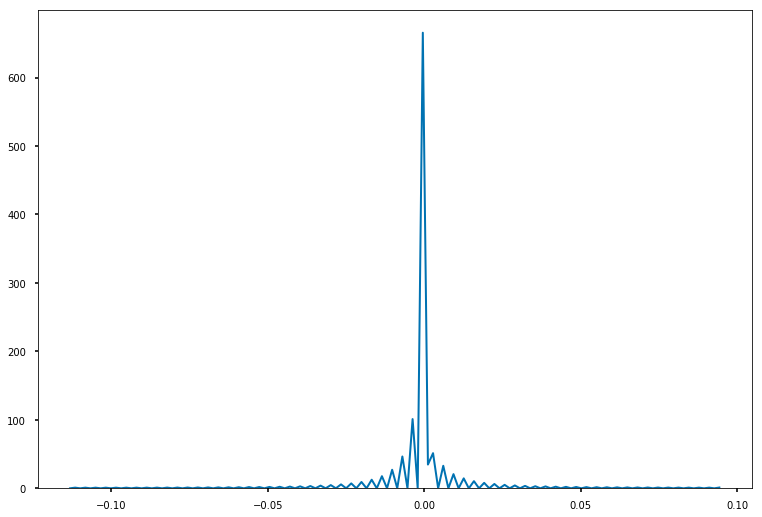

In [60]:
sns.kdeplot((psfs[3,3]-psfs[0,0]).flatten())

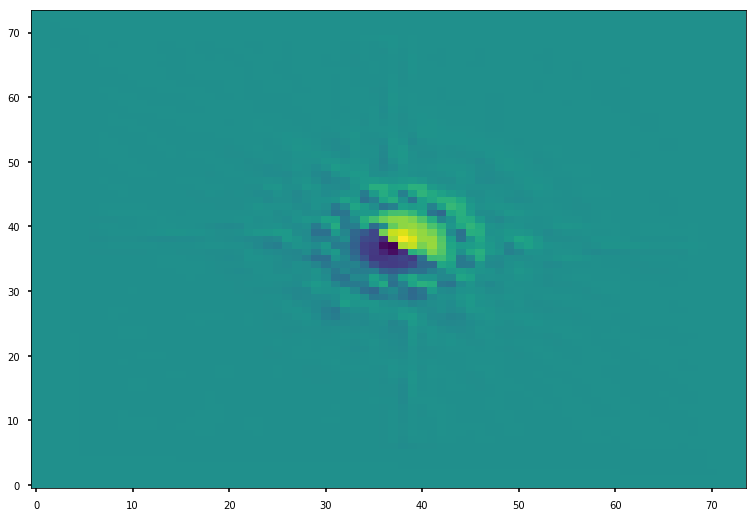

In [62]:
plt.imshow(psfs[3,3]-psfs[0,0], norm=mpl.colors.SymLogNorm(1e-4, vmin=-.1, vmax=.1))

# NGC 3377

In [2]:
f = ppy.instrument.default_ngc3377_filters(1.0, 1.0)
psf1 = f[0].psf_model.psf
psf2 = f[1].psf_model.psf

In [3]:
f2 = ppy.instrument.default_ngc3377_filters(0.91, 0.99)
psf3 = f2[0].psf_model.psf
psf4 = f2[1].psf_model.psf

In [4]:
dx = 37

In [5]:
yc, xc = 1022, 1652

In [6]:
im1 = fits.getdata('../data/NGC3377/reduced/NGC3377_F850LP_drc.fits')
im1 = im1[(yc-dx):(yc+dx), (xc-dx):(xc+dx)]
im1 -= 126.9  #126.9 # sky estimate for F850LP
im1 /= im1.sum()

im2 = fits.getdata('../data/NGC3377/reduced/NGC3377_F475W_drc.fits')
im2 = im2[(yc-dx):(yc+dx), (xc-dx):(xc+dx)]
im2 -= 76.5  # 76.5 sky estimate for F850LP
im2 /= im2.sum()


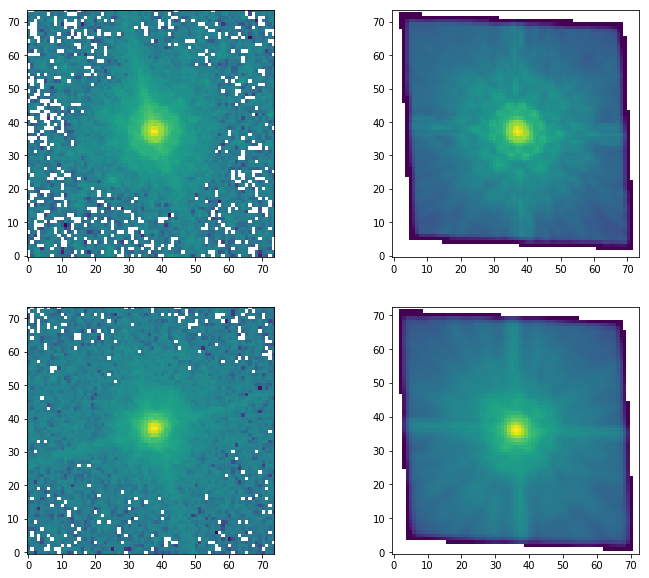

In [7]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12, 10))
norm = mpl.colors.LogNorm()
axes[0,0].imshow(im1, aspect='equal', norm=norm)
axes[0,1].imshow(psf1, aspect='equal', norm=norm)
axes[1,0].imshow(im2, aspect='equal', norm=norm)
axes[1,1].imshow(psf2, aspect='equal', norm=norm)


In [8]:
np.where(im1==im1.max())

(array([37]), array([37]))

In [9]:
np.where(psf1==psf1.max())

(array([37]), array([37]))

In [10]:
np.where(im2==im2.max())

(array([37]), array([38]))

In [11]:
np.where(psf2==psf2.max())

(array([36]), array([36]))

In [12]:
R_im1, _ = ppy.data.extraction.get_RTheta(im1, xc=37, yc=37)
R_psf1, _ = ppy.data.extraction.get_RTheta(psf1, xc=37, yc=37)

R_im2, _ = ppy.data.extraction.get_RTheta(im2, xc=38, yc=37)
R_psf2, _ = ppy.data.extraction.get_RTheta(psf2, xc=36, yc=36)


In [13]:
def plot_binned(x, y, ax=None, bins=None,
                nbins=100, xmin=0.1, xmax=10.,
                log=True, **kwargs):
    if bins is None:
        if log:
            bins = np.logspace(np.log10(xmin), np.log10(xmax), nbins)
        else:
            bins = np.linspace(xmin, xmax, nbins)
    args = {'x_estimator': np.median,
            'x_bins': bins,
            'x_ci': 'sd', 
             'fit_reg': False}
    args.update(kwargs)
    ax = sns.regplot(x, y, ax=ax, **args)
    return ax

Text(0.5, 1.0, 'F475W')

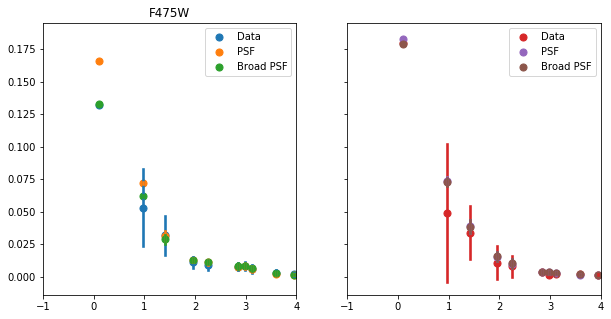

In [14]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5), sharex=True, sharey=True)
plot_binned(R_im1.flatten(), im1.flatten(), ax=axes[0], label='Data')
plot_binned(R_psf1.flatten(), psf1.flatten(), ax=axes[0], label='PSF')
plot_binned(R_psf1.flatten(), psf3.flatten(), ax=axes[0], label='Broad PSF')
plot_binned(R_im2.flatten(), im2.flatten(), ax=axes[1], label='Data')
plot_binned(R_psf2.flatten(), psf2.flatten(), ax=axes[1], label='PSF')
plot_binned(R_psf2.flatten(), psf4.flatten(), ax=axes[1], label='Broad PSF')


axes[0].legend(loc=0)
axes[0].set_title('F850LP')
axes[0].set_xlim([-1, 4])
axes[1].legend(loc=0)
axes[0].set_title('F475W')

Text(0.5, 1.0, 'F475W')

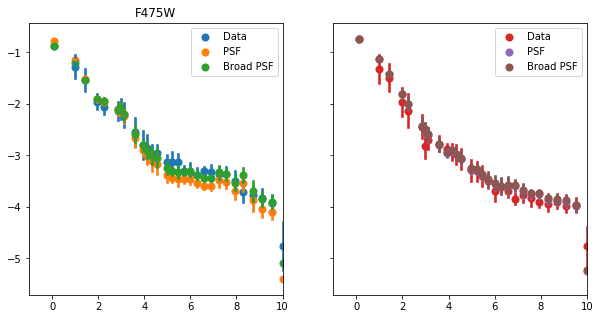

In [15]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5), sharex=True, sharey=True)
plot_binned(R_im1.flatten(), np.log10(im1.flatten()), ax=axes[0], label='Data')
plot_binned(R_psf1.flatten(), np.log10(psf1.flatten()), ax=axes[0], label='PSF')
plot_binned(R_psf1.flatten(), np.log10(psf3.flatten()), ax=axes[0], label='Broad PSF')
plot_binned(R_im2.flatten(), np.log10(im2.flatten()), ax=axes[1], label='Data')
plot_binned(R_psf2.flatten(), np.log10(psf2.flatten()), ax=axes[1], label='PSF')
plot_binned(R_psf2.flatten(), np.log10(psf4.flatten()), ax=axes[1], label='Broad PSF')

axes[0].legend(loc=0)
axes[0].set_title('F850LP')
axes[0].set_xlim([-1, 10])
axes[1].legend(loc=0)
axes[1].set_title('F475W')

# M87

In [294]:
f = ppy.instrument.default_m87_filters(1.0, 1.0)
psf1 = f[0].psf_model.psf
psf2 = f[1].psf_model.psf

In [418]:
f2 = ppy.instrument.default_m87_filters(0.98, 0.92)
psf3 = f2[0].psf_model.psf
psf4 = f2[1].psf_model.psf

In [419]:
dx = 37

In [420]:
xc, yc = 1294, 301

In [421]:
im1 = fits.getdata('../data/M87/reduced/M87_F814W_drc.fits')
im1 = im1[(yc-dx):(yc+dx), (xc-dx):(xc+dx)]
im1 -= 650 #292.8 # sky estimate for F814W
im2 = fits.getdata('../data/M87/reduced/M87_F606W_drc.fits')
im2 = im2[(yc-dx):(yc+dx), (xc-dx):(xc+dx)]
im2 -= 700  # median near source# 377.1 sky estimate for F606W

In [422]:
np.where(im1==im1.max())

(array([37]), array([36]))

In [423]:
np.where(psf1==psf1.max())

(array([37]), array([37]))

In [424]:
np.where(im2==im2.max())

(array([37]), array([36]))

In [425]:
np.where(psf2==psf2.max())

(array([36]), array([36]))

In [426]:
R_im1, _ = ppy.data.extraction.get_RTheta(im1, xc=36, yc=37)
R_psf1, _ = ppy.data.extraction.get_RTheta(psf1, xc=37, yc=37)

R_im2, _ = ppy.data.extraction.get_RTheta(im2, xc=36, yc=37)
R_psf2, _ = ppy.data.extraction.get_RTheta(psf2, xc=36, yc=36)

In [427]:
im1 /= im1[R_im1<=10].sum()
im2 /= im2[R_im2<=10].sum()
# psf1 /= psf1[R_psf1<=10].sum()
# psf2 /= psf2[R_psf2<=10].sum()
# psf3 /= psf3[R_psf1<=10].sum()
# psf4 /= psf4[R_psf2<=10].sum()

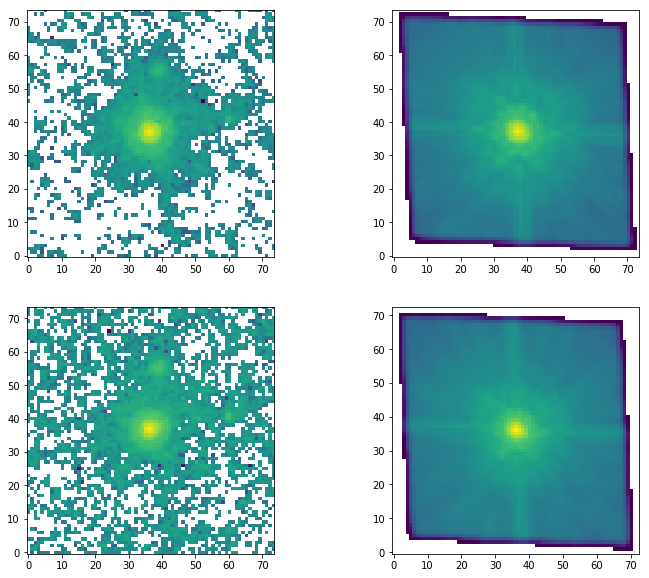

In [428]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12, 10))
norm = mpl.colors.LogNorm()
axes[0,0].imshow(im1, aspect='equal', norm=norm)
axes[0,1].imshow(psf1, aspect='equal', norm=norm)
axes[1,0].imshow(im2, aspect='equal', norm=norm)
axes[1,1].imshow(psf2, aspect='equal', norm=norm)


Text(0.5, 1.0, 'F606W')

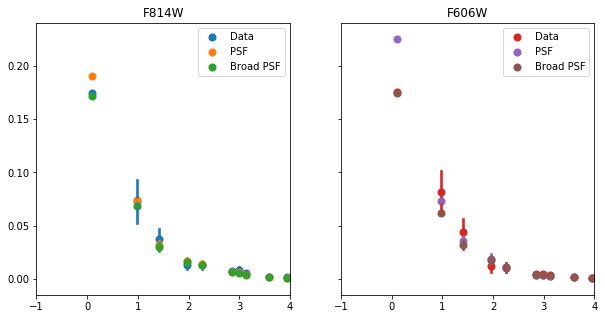

In [429]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5), sharex=True, sharey=True)
plot_binned(R_im1.flatten(), im1.flatten(), ax=axes[0], label='Data')
plot_binned(R_psf1.flatten(), psf1.flatten(), ax=axes[0], label='PSF')
plot_binned(R_psf1.flatten(), psf3.flatten(), ax=axes[0], label='Broad PSF')
plot_binned(R_im2.flatten(), im2.flatten(), ax=axes[1], label='Data')
plot_binned(R_psf2.flatten(), psf2.flatten(), ax=axes[1], label='PSF')
plot_binned(R_psf2.flatten(), psf4.flatten(), ax=axes[1], label='Broad PSF')


axes[0].legend(loc=0)
axes[0].set_title('F814W')
axes[0].set_xlim([-1, 4])
axes[1].legend(loc=0)
axes[1].set_title('F606W')

Text(0.5, 1.0, 'F475W')

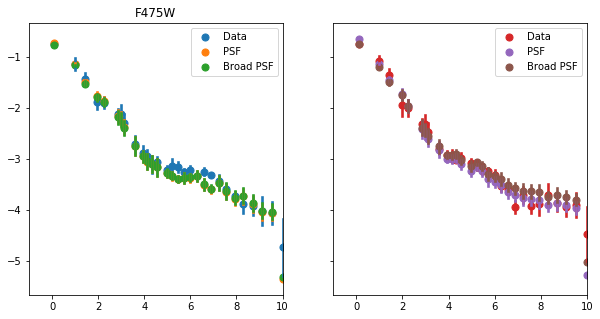

In [430]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5), sharex=True, sharey=True)
plot_binned(R_im1.flatten(), np.log10(im1.flatten()), ax=axes[0], label='Data')
plot_binned(R_psf1.flatten(), np.log10(psf1.flatten()), ax=axes[0], label='PSF')
plot_binned(R_psf1.flatten(), np.log10(psf3.flatten()), ax=axes[0], label='Broad PSF')
plot_binned(R_im2.flatten(), np.log10(im2.flatten()), ax=axes[1], label='Data')
plot_binned(R_psf2.flatten(), np.log10(psf2.flatten()), ax=axes[1], label='PSF')
plot_binned(R_psf2.flatten(), np.log10(psf4.flatten()), ax=axes[1], label='Broad PSF')

axes[0].legend(loc=0)
axes[0].set_title('F814W')
axes[0].set_xlim([-1, 4])
axes[1].legend(loc=0)
axes[1].set_title('F606W')

# M49

In [512]:
f = ppy.instrument.default_m49_filters(1.0, 1.0)
psf1 = f[0].psf_model.psf
psf2 = f[1].psf_model.psf

In [536]:
f2 = ppy.instrument.default_m49_filters(0.87, 0.95)
psf3 = f2[0].psf_model.psf
psf4 = f2[1].psf_model.psf

In [537]:
dx = 37

In [538]:
xc, yc = 4274, 3723

In [539]:
im1 = fits.getdata('../data/M49/reduced/M49_F850LP_drc.fits')
im1 = im1[(yc-dx):(yc+dx), (xc-dx):(xc+dx)]
im1 -= 180 #292.8 # sky estimate for F814W
im2 = fits.getdata('../data/M49/reduced/M49_F475W_drc.fits')
im2 = im2[(yc-dx):(yc+dx), (xc-dx):(xc+dx)]
im2 -= 110  # median near source# 377.1 sky estimate for F606W

In [540]:
np.where(im1==im1.max())

(array([37]), array([37]))

In [541]:
np.where(psf1==psf1.max())

(array([37]), array([37]))

In [542]:
np.where(im2==im2.max())

(array([37]), array([37]))

In [543]:
np.where(psf2==psf2.max())

(array([36]), array([36]))

In [544]:
R_im1, _ = ppy.data.extraction.get_RTheta(im1, xc=37, yc=37)
R_psf1, _ = ppy.data.extraction.get_RTheta(psf1, xc=37, yc=37)

R_im2, _ = ppy.data.extraction.get_RTheta(im2, xc=37, yc=37)
R_psf2, _ = ppy.data.extraction.get_RTheta(psf2, xc=36, yc=36)

In [545]:
im1 /= im1[R_im1<=20].sum()
im2 /= im2[R_im2<=20].sum()
# psf1 /= psf1[R_psf1<=10].sum()
# psf2 /= psf2[R_psf2<=10].sum()
# psf3 /= psf3[R_psf1<=10].sum()
# psf4 /= psf4[R_psf2<=10].sum()

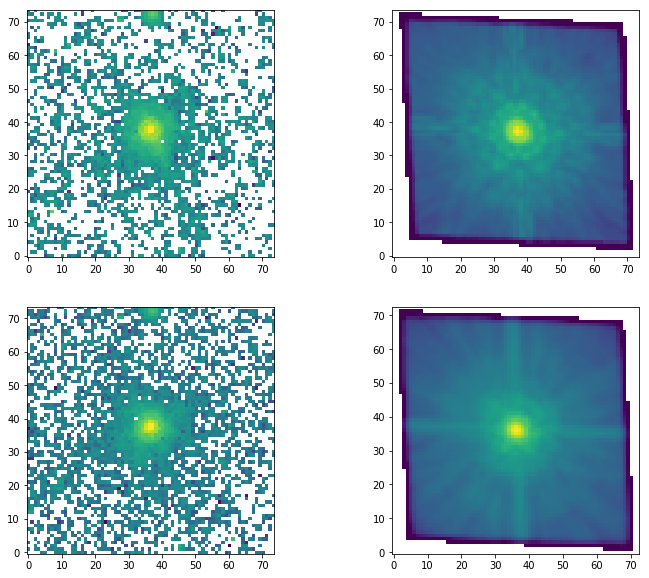

In [546]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12, 10))
norm = mpl.colors.LogNorm()
axes[0,0].imshow(im1, aspect='equal', norm=norm)
axes[0,1].imshow(psf1, aspect='equal', norm=norm)
axes[1,0].imshow(im2, aspect='equal', norm=norm)
axes[1,1].imshow(psf2, aspect='equal', norm=norm)


Text(0.5, 1.0, 'F475W')

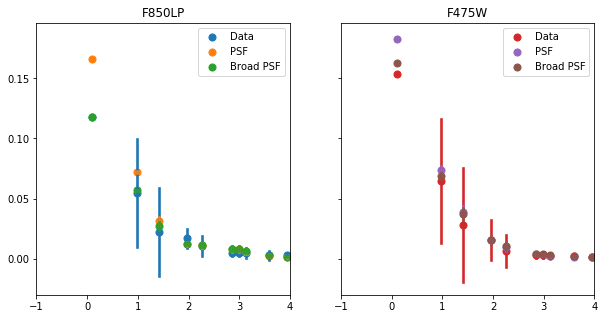

In [547]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5), sharex=True, sharey=True)
plot_binned(R_im1.flatten(), im1.flatten(), ax=axes[0], label='Data')
plot_binned(R_psf1.flatten(), psf1.flatten(), ax=axes[0], label='PSF')
plot_binned(R_psf1.flatten(), psf3.flatten(), ax=axes[0], label='Broad PSF')
plot_binned(R_im2.flatten(), im2.flatten(), ax=axes[1], label='Data')
plot_binned(R_psf2.flatten(), psf2.flatten(), ax=axes[1], label='PSF')
plot_binned(R_psf2.flatten(), psf4.flatten(), ax=axes[1], label='Broad PSF')


axes[0].legend(loc=0)
axes[0].set_title('F850LP')
axes[0].set_xlim([-1, 4])
axes[1].legend(loc=0)
axes[1].set_title('F475W')

Text(0.5, 1.0, 'F475W')

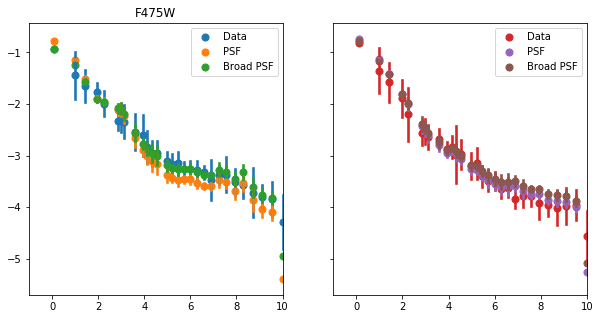

In [548]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5), sharex=True, sharey=True)
plot_binned(R_im1.flatten(), np.log10(im1.flatten()), ax=axes[0], label='Data')
plot_binned(R_psf1.flatten(), np.log10(psf1.flatten()), ax=axes[0], label='PSF')
plot_binned(R_psf1.flatten(), np.log10(psf3.flatten()), ax=axes[0], label='Broad PSF')
plot_binned(R_im2.flatten(), np.log10(im2.flatten()), ax=axes[1], label='Data')
plot_binned(R_psf2.flatten(), np.log10(psf2.flatten()), ax=axes[1], label='PSF')
plot_binned(R_psf2.flatten(), np.log10(psf4.flatten()), ax=axes[1], label='Broad PSF')

axes[0].legend(loc=0)
axes[0].set_title('F850LP')
axes[0].set_xlim([-1, 10])
axes[1].legend(loc=0)
axes[0].set_title('F475W')